In [196]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, date, time

plt.rcParams["figure.figsize"] = (10,7)
plt.style.use('ggplot')

In [197]:
df = pd.read_csv('data.csv', delimiter=';', parse_dates=['dt'], decimal=",") 

импортировали библиотеки и загрузили файл с данными, просмотрим первые  10 значений и информацию о датасете

In [198]:
df.head(10)

,player_id,dt,battles,revenue
0,1761375733,2019-03-18,2,0.0
1,5142722405,2019-04-05,6,0.0
2,6336768620,2019-03-16,27,0.0
3,6769868103,2019-04-29,2,0.0
4,7080232366,2019-04-14,60,0.0
5,1360266281,2019-04-29,3,0.0
6,7199927670,2019-03-17,134,0.0
7,4175820410,2019-05-21,31,0.0
8,3913887322,2019-04-22,19,0.0
9,4685866667,2019-09-04,110,0.0


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551016 entries, 0 to 551015
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   player_id  551016 non-null  int64         
 1   dt         551016 non-null  datetime64[ns]
 2   battles    551016 non-null  int64         
 3   revenue    551016 non-null  float64       
 4   weekday    551016 non-null  object        
 5   week_id    551016 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 25.2+ MB


Видим 4 столбца, и что данные были правильно распарсены (изменен тип object на datetime и float для двух столбцов). количество значений в столбцах совпадает, значит пропусков данных не наблюдается, и по всей видимости, данные хорошо предобработаны. можно на всякий случай сделать проверку на дубликаты данных

In [200]:
df.duplicated().sum()

0

как видим, дубликатов не обнаружено, переходим к анализу данных. 
Построим первые предварительные графики, что бы пронаблюдать общую тенденцию в течении времени в собранном датасете, наблюдается ли явный прирост/спад проведенных битв, внесенных денежных средств и количества играющих людей.

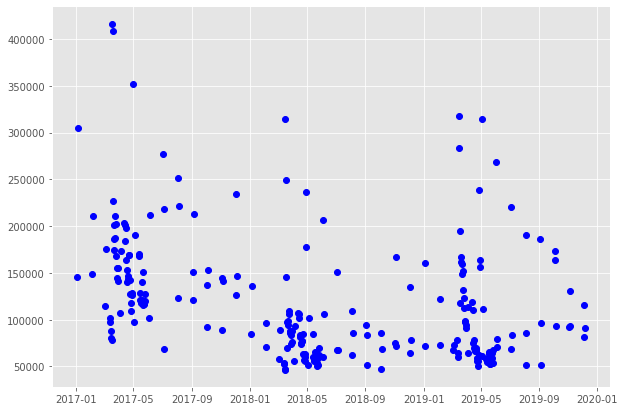

In [268]:
plt.plot(df.groupby(['dt'])['battles'].sum(), 'bo') #график количества боёв в день

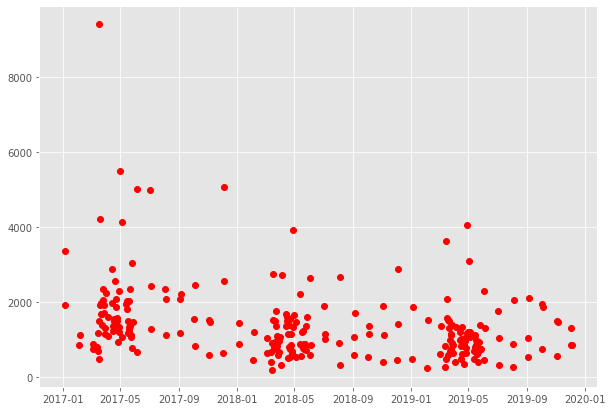

In [204]:
plt.plot(df.groupby(['dt'])['revenue'].sum(), 'ro') #график количества внесенных денег в день

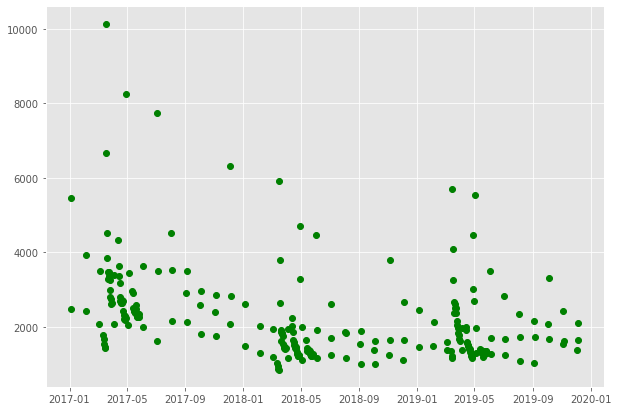

In [205]:
plt.plot(df.groupby(['dt'])['player_id'].count(), 'go') #график количество игроков в день

Как мы видим, выборка по трём графикам имеет похожую тенденцию и сконцентрирована возле майского месяца, что скорее всего связано с проводимым турниром. для более наглядного рассмотрения сгруппируем данные по месяцам и визуализируем столбчатыми графиками.

In [206]:
z = df.groupby('player_id', as_index=False)['dt'].min() #первый день игрока(новый игрок)
x = z.groupby('dt', as_index=False)['player_id'].count(
).sort_values(by='player_id',ascending=False) #сколько новых игроков в данный день
x.head()

,dt,player_id
11,2017-03-18,6313
1,2017-01-05,4474
80,2018-03-17,3853
64,2017-07-03,3629
147,2019-03-16,3348


In [212]:
q = df.groupby(pd.Grouper(key='dt', freq="M"))['battles'].sum()
w = df.groupby(pd.Grouper(key='dt', freq="M"))['player_id'].count()
e = df.groupby(pd.Grouper(key='dt', freq="M"))['revenue'].sum()
data_by_month = pd.concat([w,q, e], axis=1)
data_by_month.reset_index(level=0, inplace=True)
data_by_month.head()

,dt,player_id,battles,revenue
0,2017-01-31,7928,450639,5302.95
1,2017-02-28,6354,360010,1979.45
2,2017-03-31,69274,3716409,41296.92
3,2017-04-30,60753,3257435,36953.84
4,2017-05-31,42265,2242020,29533.45


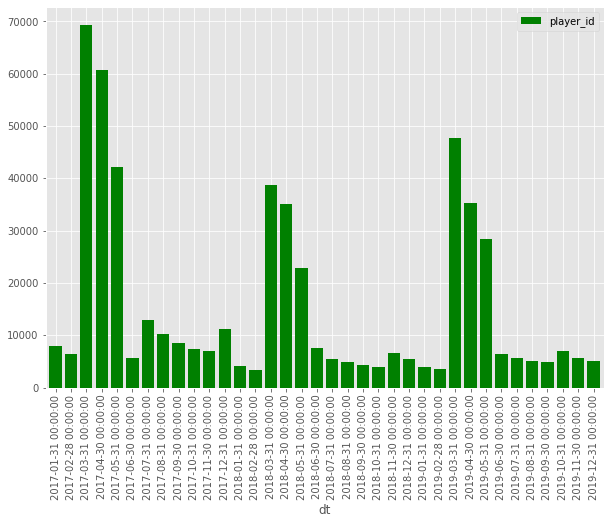

In [217]:
data_by_month.plot.bar('dt','player_id',width=0.8, linewidth=1, color='g') #игроков в месяц

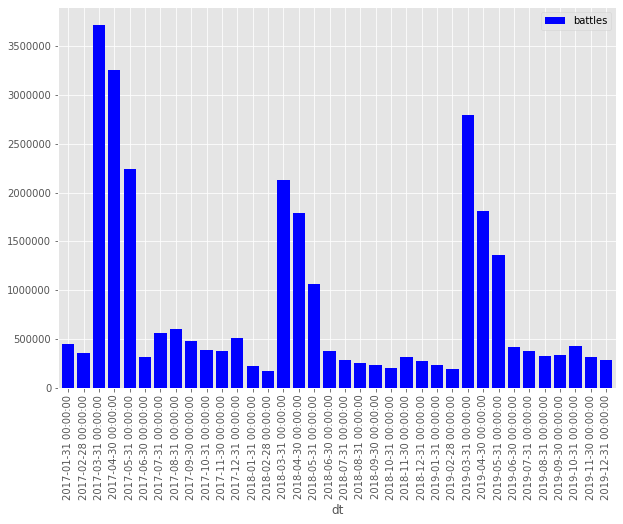

In [218]:
data_by_month.plot.bar('dt','battles',width=0.8, linewidth=1, color='b') #боёв в месяц

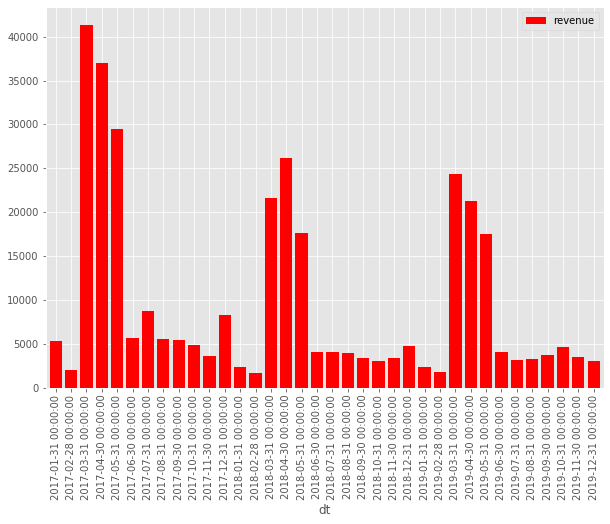

In [219]:
data_by_month.plot.bar('dt','revenue',width=0.8, linewidth=1, color='r') #внесено денег в месяц

таким образом, мы видим чёткие пики сконцентрированные около апреля, разделим данные на на пики с захватом 3х месяцев от марта до мая

In [267]:
peak17 = df.loc[(data['dt'] < '2017-06-01') & (df['dt'] > '2017-02-28')]
peak18 = df.loc[(data['dt'] < '2018-06-01') & (df['dt'] > '2018-02-28')]
peak19 = df.loc[(data['dt'] < '2019-06-01') & (df['dt'] > '2019-02-28')]

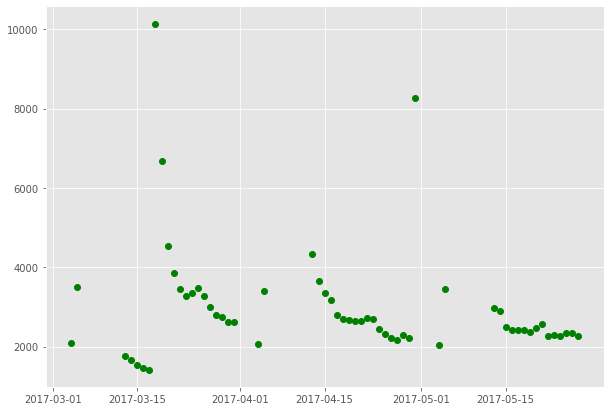

In [243]:
plt.plot(peak17.groupby(['dt'])['player_id'].count(), 'go')

при ближайшем рассмотрении видим, что каждый пик состоит из трёх подпиков.. возможно это связано с днями недели.. предположим, что в выходные люди играют чаще..
выявим день недели по дате и добавим два столбца данных к датасету 'день недели' и 'id дня недели' (0-пн, 1-вт, 2-ср и т.д.)

In [271]:
data = df
data.insert(4,'weekday', data['dt'].dt.day_name())
data.insert(5,'week_id', data['dt'].dt.dayofweek)

ValueError: cannot insert weekday, already exists

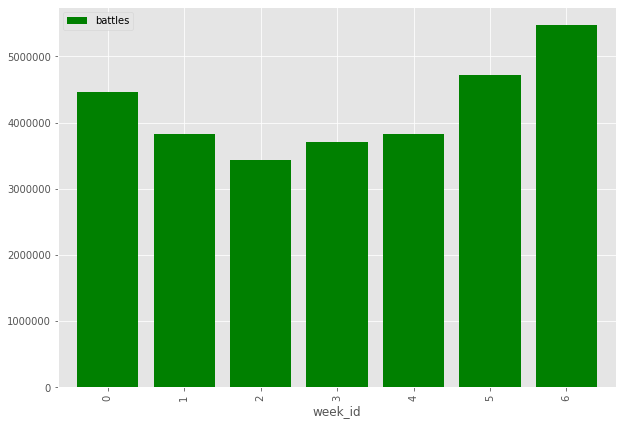

In [298]:
data.groupby(['week_id'])['battles'].sum().to_frame().sort_values(by='week_id').plot.bar(width=0.8, linewidth=1, color='g')

Здесь мы видим, что действительно, в основном сражения происходят в воскресение, чуть меньше в субботу и на третьем месте понедельник, меньше всего играют по средам.
Теперь вычислим топовых игроков, кто провёл больше всего битв, за время выборки, внес больше всего денег, проявляет самую высокую активность, а также просмотрим средние значения по выборке..

In [316]:
aggregated_data = df.groupby(['player_id']).agg(**{'First Day' : pd.NamedAgg(column='dt', aggfunc=min),
                               'Last Day' : pd.NamedAgg(column='dt', aggfunc=max),
                               'Delta Day' : pd.NamedAgg(column='dt', aggfunc= lambda x : ((max(x) - min(x) + '1 day').days)),
                               'Battles Day' : pd.NamedAgg(column='dt', aggfunc='count'), 
                               'Battles Count' : pd.NamedAgg(column='battles', aggfunc=sum), 
                               'Revenue Count' : pd.NamedAgg(column='revenue', aggfunc= lambda x : sum(map(lambda i: i > 0, x))), 
                               'Revenue Sum' : pd.NamedAgg(column='revenue', aggfunc=sum)})

In [321]:
aggregated_data[['Battles Day','Battles Count','Revenue Sum']].sort_values(by='Battles Count', ascending = False).head()

,Battles Day,Battles Count,Revenue Sum
player_id,,,
3937017531,71,18033,0.00
1871618189,78,16333,1056.49
7178881223,83,16242,771.04
1609956240,80,16080,22.78
8797101107,70,14789,334.90


Здесь выведено топ 5 игроков по проведенным битвам.
Стоит пояснить:
Battles Day - сколько дней игрок играл (провёл хотя бы один бой)
Battles Count - сколько битв всего он сыграл
Revenue Sum - сколько он внёс денежных средств

Посмотрим, кто лидирует по внесенным денежным средствам..

In [323]:
aggregated_data[['Battles Day','Battles Count','Revenue Sum']].sort_values(by='Revenue Sum', ascending = False).head()

,Battles Day,Battles Count,Revenue Sum
player_id,,,
1615792575,76,9031,1993.86
2605365678,73,5409,1515.45
5175944443,67,4844,1289.06
8291614094,35,2563,1129.93
8393696122,73,5496,1126.95


Это топ 5 игроков по внесенных суммам за весь период их игры

In [324]:
aggregated_data[['Battles Day','Battles Count','Revenue Sum']].sort_values(by='Battles Day', ascending = False).head()

,Battles Day,Battles Count,Revenue Sum
player_id,,,
9140047915,84,7564,347.85
3245924314,83,7272,0.00
5583063040,83,11964,0.00
2565420612,83,6274,14.70
7178881223,83,16242,771.04


Только один человек пересёкся в хотя бы двух выборках, это id 7178881223... хм, выглядит как один из наших постоянных и ценных игроков, нам явно не следует его терять из виду и возможно предложить пару бонусов..:)
Теперь попробуем ввести коэффициенты активности игроков по проведенным битвам и по внесенным деньгам.

In [329]:
aggregated_data['Koef Activity By Battles'] = aggregated_data['Battles Day']/aggregated_data['Delta Day']
aggregated_data['Koef Activity By Revenue'] = aggregated_data['Revenue Count']/aggregated_data['Delta Day']

In [330]:
aggregated_data[aggregated_data['Koef Activity By Battles'] > 0].sort_values(by = 'Koef Activity By Battles', ascending = False).head()

,First Day,Last Day,Delta Day,Battles Day,Battles Count,Revenue Count,Revenue Sum,Koef Activity By Battles,Koef Activity By Revenue
player_id,,,,,,,,,
6269794050,2019-03-16,2019-03-16,1,1,2,0.0,0.0,1.0,0.0
3224534144,2018-03-17,2018-03-18,2,2,97,0.0,0.0,1.0,0.0
6817936968,2019-03-16,2019-03-16,1,1,8,0.0,0.0,1.0,0.0
6817809559,2018-04-29,2018-04-30,2,2,28,0.0,0.0,1.0,0.0
8034346963,2019-05-03,2019-05-03,1,1,12,0.0,0.0,1.0,0.0


In [331]:
aggregated_data[aggregated_data['Koef Activity By Revenue'] > 0].sort_values(by = 'Koef Activity By Revenue', ascending = False).head()

,First Day,Last Day,Delta Day,Battles Day,Battles Count,Revenue Count,Revenue Sum,Koef Activity By Battles,Koef Activity By Revenue
player_id,,,,,,,,,
1516310689,2018-04-29,2018-04-29,1,1,64,1.0,41.91,1.0,1.0
3648765878,2017-04-30,2017-04-30,1,1,81,1.0,1.85,1.0,1.0
1237541593,2018-03-17,2018-03-17,1,1,30,1.0,2.44,1.0,1.0
3704586610,2018-03-17,2018-03-17,1,1,11,1.0,1.46,1.0,1.0
2237922632,2017-03-18,2017-03-18,1,1,13,1.0,79.25,1.0,1.0


Да, выглядит как не удачная попытка, пробуя ввести коэффициенты как (отношение дней в которые игрок играл к периоду с момента первой регистрации и до последней) - для активности по битвам (Koef Activity By Battles) и как (отношение дней, когда игрок приносил прибыль к периоду с момента первой регистрации и до последней) - для активности по прибыли (Koef Activity By Revenue), нужно учитывать то, что это может быть просто игрок в выборке, который провёл лишь один день в игре. что ж, тогда найдем средние значения и посмотрим кто лидирует по коэффициентам, при этом превышая средние показатели.

In [ ]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [347]:
mean_count = Average(aggregated_data['Battles Day']) 
print(mean_count)
aggregated_data[(aggregated_data['Koef Activity By Battles'] > 0) & (aggregated_data['Battles Day'] > mean_count)].sort_values(by='Koef Activity By Battles', ascending = False).head()

9.41022969857399


,First Day,Last Day,Delta Day,Battles Day,Battles Count,Revenue Count,Revenue Sum,Koef Activity By Battles,Koef Activity By Revenue
player_id,,,,,,,,,
5581048274,2019-03-16,2019-03-28,13,13,929,0.0,0.0,1.0,0.0
5627551425,2019-03-16,2019-03-25,10,10,790,0.0,0.0,1.0,0.0
2400853522,2019-03-16,2019-03-25,10,10,1473,0.0,0.0,1.0,0.0
2377626525,2018-03-17,2018-03-28,12,12,700,0.0,0.0,1.0,0.0
5399234068,2017-03-18,2017-03-29,12,12,538,0.0,0.0,1.0,0.0


In [348]:
aggregated_data[(aggregated_data['Koef Activity By Revenue'] > 0) & (aggregated_data['Battles Day'] > mean_count)].sort_values(by='Koef Activity By Revenue', ascending = False).head()

,First Day,Last Day,Delta Day,Battles Day,Battles Count,Revenue Count,Revenue Sum,Koef Activity By Battles,Koef Activity By Revenue
player_id,,,,,,,,,
7705495782,2018-03-17,2018-03-28,12,12,1390,6.0,134.25,1.000000,0.500000
1501332279,2019-03-16,2019-03-30,15,11,1088,5.0,160.40,0.733333,0.333333
2463563216,2017-03-18,2017-03-28,11,10,240,3.0,81.15,0.909091,0.272727
8406546953,2019-03-16,2019-03-27,12,12,1599,3.0,20.57,1.000000,0.250000
3418461292,2019-03-16,2019-03-30,15,13,1032,3.0,224.18,0.866667,0.200000


Таким образом мы видим топ игроков, которые ни дня не пропустили играя и игроков, которые почти каждый игровой день приносят нам прибыль

К сожалению, это пока всё, что я успела сделать с данными, хотя здесь ещё столько возможностей для анализа..